# RF Complexity Analysis (EU)
## Data Loading

We use the `forest_report.json` file in the repo. Each entry contains the dataset name, metadata (sizes, series length, split), and trained forest statistics.

In [17]:
from __future__ import annotations

from pathlib import Path
from typing import Any, Mapping
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

# Optional styling (if unavailable, neutral fallback)
try:
    from etl.table_styling import style_summary_table, print_color_legend
except Exception:
    def style_summary_table(df: pd.DataFrame):
        return df.style
    def print_color_legend():
        pass

REPORT_PATH = Path('forest_report.json')
assert REPORT_PATH.exists(), f'File not found: {REPORT_PATH}'
with REPORT_PATH.open('r', encoding='utf-8') as f:
    report_data: list[dict[str, Any]] = json.load(f)
print(f'Loaded {len(report_data)} rows from {REPORT_PATH}')



Loaded 88 rows from forest_report.json


## Summary Table

We build a table with: `dataset`, `analyzed` (if results exist in `results/`), `n_estimators`, EU complexity metrics (`n_features`, `mean_eu`, `eu_complexity`), sizes (`series_length`, `train_size`, `test_size`), and forest stats (`avg_depth`, `avg_leaves`, `avg_nodes`).

Correct sorting (priority):
- `n_estimators` ascending
- `eu_complexity` ascending (fallback to `series_length` when missing)
- `series_length` ascending
- `dataset` alphabetical


In [18]:
# Cell 6 — Build table with correct sorting (EU count)
def to_int(value: Any | None) -> int | None:
    try:
        return int(value)
    except (TypeError, ValueError):
        return None

def to_float(value: Any | None) -> float | None:
    try:
        return float(value)
    except (TypeError, ValueError):
        return None

def extract_metadata(entry: Mapping[str, Any]) -> dict[str, Any]:
    metadata = entry.get('metadata') if isinstance(entry.get('metadata'), Mapping) else {}
    statistics = entry.get('forest_statistics') if isinstance(entry.get('forest_statistics'), Mapping) else {}
    dataset = str(entry.get('dataset', '') or '').strip() or '<unknown>'
    return {
        'dataset': dataset,
        'n_estimators': to_int(statistics.get('n_estimators')),
        'series_length': to_int(metadata.get('series_length')),
        'train_size': to_int(metadata.get('train_size')),
        'test_size': to_int(metadata.get('test_size')),
        'avg_depth': to_float(statistics.get('avg_depth')),
        'avg_leaves': to_float(statistics.get('avg_leaves')),
        'avg_nodes': to_float(statistics.get('avg_nodes')),
    }

def build_eu_metrics(entries: list[Mapping[str, Any]]) -> dict[str, dict[str, Any]]:
    eu: dict[str, dict[str, Any]] = {}
    for e in entries:
        dataset = str(e.get('dataset', '') or '').strip()
        if not dataset:
            continue
        n_features = e.get('n_features') if isinstance(e.get('n_features'), (int, float)) else None
        mean_eu = e.get('mean_eu') if isinstance(e.get('mean_eu'), (int, float)) else None
        eu_complexity = e.get('eu_complexity') if isinstance(e.get('eu_complexity'), (int, float)) else None
        # Try deriving from endpoint dictionaries (consider common key variants)
        eu_obj = e.get('endpoints_universe') or e.get('endpoints') or e.get('endpoints_universe_summary')
        lengths = None
        if isinstance(eu_obj, Mapping):
            lens: list[int] = []
            for _, endpoints in eu_obj.items():
                if isinstance(endpoints, (list, tuple)):
                    lens.append(len(endpoints))
            if lens:
                lengths = lens
                comp_n = len(lens)
                comp_mean = float(np.mean(lens))
                comp_cplx = comp_mean * comp_n
                if n_features is None:
                    n_features = comp_n
                if mean_eu is None:
                    mean_eu = comp_mean
                if eu_complexity is None:
                    eu_complexity = comp_cplx
        if n_features is not None and mean_eu is not None:
            eu[dataset] = {
                'n_features': int(n_features),
                'mean_eu': float(mean_eu),
                'eu_complexity': float(eu_complexity) if eu_complexity is not None else float(mean_eu) * int(n_features),
                'lengths': lengths,
            }
    return eu

# Build summary dataframe + EU metrics
summary_df = pd.DataFrame([extract_metadata(e) for e in report_data])
eu_metrics = build_eu_metrics(report_data)

summary_df['n_features'] = summary_df['dataset'].apply(lambda d: eu_metrics.get(d, {}).get('n_features'))
summary_df['mean_eu'] = summary_df['dataset'].apply(lambda d: eu_metrics.get(d, {}).get('mean_eu'))
summary_df['eu_complexity'] = summary_df['dataset'].apply(lambda d: eu_metrics.get(d, {}).get('eu_complexity'))

# 'analyzed' column if zip files exist in results/
results_dir = Path('results')
if results_dir.exists():
    zips = [p.name for p in results_dir.iterdir() if p.is_file() and p.suffix == '.zip']
    done = {name.split('_')[0] for name in zips}
    summary_df['analyzed'] = summary_df['dataset'].apply(lambda d: 'YES' if d in done else 'NO')
else:
    summary_df['analyzed'] = 'N/A'

# Sorting: n_estimators → eu_complexity (fallback series_length) → series_length → dataset
INF = float('inf')
summary_df['_sort_n_estimators'] = summary_df['n_estimators'].fillna(INF)
summary_df['_sort_eu'] = summary_df.apply(
    lambda r: r['eu_complexity'] if pd.notna(r.get('eu_complexity')) else (r['series_length'] if pd.notna(r.get('series_length')) else INF),
    axis=1,
)
summary_df['_sort_series_length'] = summary_df['series_length'].fillna(INF)
summary_df = (
    summary_df
    .sort_values(['_sort_n_estimators', '_sort_eu', '_sort_series_length', 'dataset'], ascending=[True, True, True, True])
    .drop(columns=['_sort_n_estimators', '_sort_eu', '_sort_series_length'])
)
summary_df = summary_df.reset_index(drop=True)

eu_only_df = summary_df[summary_df['eu_complexity'].notna()].copy()

# Riordino colonne secondo la sequenza richiesta
desired_order = [
    'dataset', 'analyzed', 'n_estimators', 'eu_complexity',
    'series_length', 'mean_eu', 'n_features', 'train_size', 'test_size',
    'avg_depth', 'avg_leaves', 'avg_nodes'
]
summary_df = summary_df[[col for col in desired_order if col in summary_df.columns]]

style_summary_table(summary_df)


C:\Users\danie\Projects\GitHub\drifts\etl\table_styling.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(analyzed_style, subset=['analyzed'])


,dataset,analyzed,n_estimators,eu_complexity,series_length,mean_eu,n_features,train_size,test_size,avg_depth,avg_leaves,avg_nodes
0,Wine,NO,10.000000,297.000000,234,3.453488,86.000000,57,54,2.600000,4.400000,7.800000
1,Wafer,YES,10.000000,603.000000,152,4.674419,129.000000,1000,6164,6.800000,13.200000,25.400000
2,MiddlePhalanxOutlineCorrect,YES,10.000000,1440.000000,80,18.000000,80.000000,600,291,8.000000,35.600000,70.200000
3,MelbournePedestrian,YES,10.000000,1456.000000,24,60.666667,24.000000,1138,2319,9.300000,40.200000,79.400000
4,ChlorineConcentration,YES,10.000000,1792.000000,166,10.795181,166.000000,467,3840,15.100000,39.400000,77.800000
5,ScreenType,NO,10.000000,2618.000000,720,4.363333,600.000000,375,375,0.200000,1.200000,1.400000
6,FordA,NO,10.000000,8811.000000,500,17.622000,500.000000,3601,1320,10.300000,30.000000,59.000000
7,FordB,NO,10.000000,8964.000000,500,17.928000,500.000000,3636,810,12.200000,30.000000,59.000000
8,ElectricDevices,YES,10.000000,29847.000000,96,310.906250,96.000000,8926,7711,26.600000,360.900000,720.800000
9,SonyAIBORobotSurface1,YES,17.000000,106.000000,70,3.312500,32.000000,20,601,1.647059,2.705882,4.411765


In [19]:
analyzed_true_df = summary_df[summary_df['analyzed'] == 'YES']
#display(analyzed_true_df)
style_summary_table(analyzed_true_df)

C:\Users\danie\Projects\GitHub\drifts\etl\table_styling.py:30: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = styled.applymap(analyzed_style, subset=['analyzed'])


,dataset,analyzed,n_estimators,eu_complexity,series_length,mean_eu,n_features,train_size,test_size,avg_depth,avg_leaves,avg_nodes
1,Wafer,YES,10.000000,603.000000,152,4.674419,129.000000,1000,6164,6.800000,13.200000,25.400000
2,MiddlePhalanxOutlineCorrect,YES,10.000000,1440.000000,80,18.000000,80.000000,600,291,8.000000,35.600000,70.200000
3,MelbournePedestrian,YES,10.000000,1456.000000,24,60.666667,24.000000,1138,2319,9.300000,40.200000,79.400000
4,ChlorineConcentration,YES,10.000000,1792.000000,166,10.795181,166.000000,467,3840,15.100000,39.400000,77.800000
8,ElectricDevices,YES,10.000000,29847.000000,96,310.906250,96.000000,8926,7711,26.600000,360.900000,720.800000
9,SonyAIBORobotSurface1,YES,17.000000,106.000000,70,3.312500,32.000000,20,601,1.647059,2.705882,4.411765
15,HandOutlines,YES,59.000000,2862.000000,2709,3.252273,880.000000,1000,370,9.338983,20.000000,39.000000
20,FacesUCR,YES,92.000000,1219.000000,131,9.376923,130.000000,200,2050,6.565217,19.630435,38.260870
25,ECG200,YES,101.000000,291.000000,96,4.041667,72.000000,100,100,3.069307,4.673267,8.346535


In [20]:
from pathlib import Path

try:
    from IPython import get_ipython
    ip = get_ipython()
    BASE_DIR = Path(ip.run_line_magic('pwd', '')).resolve()
except Exception:
    BASE_DIR = Path.cwd().resolve()
RESULTS_DIR = BASE_DIR / 'results'
FR_CSV = BASE_DIR / 'forest_report.csv'


from pathlib import Path
import pandas as pd
from etl.drifts_results import compute_counts_from_results, load_analyzed_df, cast_dataset_str

# === Rilevamento automatico dei percorsi (robusto per notebook) ===
try:
    from IPython import get_ipython
    ip = get_ipython()
    BASE_DIR = Path(ip.run_line_magic('pwd', '')).resolve()
except Exception:
    BASE_DIR = Path.cwd().resolve()
RESULTS_DIR = BASE_DIR / "results"
FR_CSV = BASE_DIR / "forest_report.csv"

print("📁 BASE_DIR     :", BASE_DIR)
print("📁 RESULTS_DIR  :", RESULTS_DIR)
print("📄 FOREST_REPORT:", FR_CSV.exists())

from etl.drifts_results import DISPLAY_CATEGORIES, DISPLAY_NAMES, DISPLAY_LABELS

# === Calcolo e merge ===

counts_df = compute_counts_from_results(RESULTS_DIR, verbose=True)
analyzed_df = load_analyzed_df(FR_CSV)

counts_df   = cast_dataset_str(counts_df)
analyzed_df = cast_dataset_str(analyzed_df)

# Diagnostic: inspect zip archives for redis manifests
import zipfile
missing = []
for z in sorted(RESULTS_DIR.glob('*.zip')):
    try:
        with zipfile.ZipFile(z, 'r') as zz:
            names = zz.namelist()
            has = any('redis_backup_db' in n for n in names)
            if not has:
                missing.append((z.name, names[:10]))
    except Exception as e:
        missing.append((z.name, f'error: {e}'))

if missing:
    print('ZIP senza redis manifest (primi entry mostrati):')
    for name, sample in missing:
        print('-', name, '->', sample)
else:
    print('Tutti gli zip contengono redis_backup_db*.json (o non ci sono zip).')

# Restringi ai dataset presenti nei risultati contati
if counts_df.empty:
    print(f"Nessun redis manifest valido trovato in {RESULTS_DIR}")
    results_datasets = []
else:
    results_datasets = sorted(counts_df["dataset"].astype(str).unique())
    print('Dataset conteggiati:', ', '.join(results_datasets))

analyzed_df_res = analyzed_df[analyzed_df["dataset"].isin(results_datasets)].copy()

if results_datasets and not analyzed_df_res.empty:
    merged_results_only = analyzed_df_res.merge(counts_df, on="dataset", how="inner")
else:
    import pandas as pd  # type: ignore
    merged_results_only = pd.DataFrame(columns=["dataset", *DISPLAY_CATEGORIES])

if not merged_results_only.empty:
    for c in DISPLAY_CATEGORIES:
        if c not in merged_results_only.columns:
            merged_results_only[c] = 0
    merged_results_only[DISPLAY_CATEGORIES] = (
        merged_results_only[DISPLAY_CATEGORIES]
        .fillna(0)
        .astype(int)
    )

    merged_results_only["TOT"] = merged_results_only[DISPLAY_CATEGORIES].sum(axis=1)
    merged_results_only = merged_results_only.sort_values("R", ascending=False)

summary_cols = ["dataset", *DISPLAY_CATEGORIES, "TOT"]
summary_cols = [c for c in summary_cols if c in merged_results_only.columns]
summary = merged_results_only[summary_cols].copy()

rename_map = {c: DISPLAY_LABELS.get(c, DISPLAY_NAMES.get(c, c)) for c in DISPLAY_CATEGORIES}
rename_map["TOT"] = DISPLAY_LABELS.get("TOT", "Total")
summary = summary.rename(columns=rename_map)

log_summary = counts_df.attrs.get("log_summary", {}) if hasattr(counts_df, "attrs") else {}
summary["Worker start (min)"] = summary["dataset"].map(lambda ds: log_summary.get(ds, {}).get("log_start_min"))
summary["Worker end (max)"] = summary["dataset"].map(lambda ds: log_summary.get(ds, {}).get("log_end_max"))
summary["Worker span (s)"] = summary["dataset"].map(lambda ds: log_summary.get(ds, {}).get("log_duration_seconds"))
if "Worker span (s)" in summary.columns:
    summary["Worker span (s)"] = pd.to_numeric(summary["Worker span (s)"], errors="coerce").round(3)

try:
    _ = style_summary_table
except NameError:
    def style_summary_table(df: pd.DataFrame):
        return (
            df.style.set_properties(**{"text-align": "left"})
            .set_table_styles([{ "selector": "th", "props": [("text-align", "left")] }])
        )

style_summary_table(summary)


📁 BASE_DIR     : C:\Users\danie\Projects\GitHub\drifts
📁 RESULTS_DIR  : C:\Users\danie\Projects\GitHub\drifts\results
📄 FOREST_REPORT: True
?? Errore leggendo ChlorineConcentration_1_false_0/redis_backup_db1.json in C:\Users\danie\Projects\GitHub\drifts\results\ChlorineConcentration_1_false_0.zip
Manifest not found in C:\Users\danie\Projects\GitHub\drifts\results\ElectricDevices_1_false_0.zip
?? Errore leggendo FacesUCR_1_false_0/redis_backup_db1.json in C:\Users\danie\Projects\GitHub\drifts\results\FacesUCR_1_false_0.zip
?? Errore leggendo Wafer_-1_false_0/redis_backup_db1.json in C:\Users\danie\Projects\GitHub\drifts\results\Wafer_-1_false_0.zip
ZIP senza redis manifest (primi entry mostrati):
- ElectricDevices_1_false_0.zip -> ['ElectricDevices_1_false_0/', 'ElectricDevices_1_false_0/worker_cache_logged_worker_local_workers_7_20251024_024923.log', 'ElectricDevices_1_false_0/worker_cache_logged_worker_local_workers_21_20251023_200518.log', 'ElectricDevices_1_false_0/worker_cache_logg

,dataset,Candidate,Reason,Non-reason,Candidate Anti-reason,Anti-reason,Good profile,Bad profile,Preferred reason,Anti-reason profile,Total,Worker start (min),Worker end (max),Worker span (s)
6,SonyAIBORobotSurface1,0,4902,727,303484,12237,3784,573,0,260,325967,2025-10-25T13:54:38.357814,2025-10-25T15:50:32.599164,6954.241000
3,HandOutlines,3607,1931,411,50810,555,1865,349,0,359,59887,2025-10-25T16:18:06.781607,2025-10-26T01:18:11.677513,32404.896000
0,ChlorineConcentration,0,707,0,0,0,32,0,678,0,1417,2025-10-24T21:56:21.938372,2025-10-25T13:07:57.905980,54695.968000
7,Wafer,0,633,0,0,0,32,0,606,0,1271,2025-10-24T04:30:43.386122,2025-10-24T17:26:16.893110,46533.507000
4,MelbournePedestrian,38823,239,0,0,0,32,0,243,0,39337,2025-10-23T01:55:33.429803,2025-10-23T10:58:45.392791,32591.963000
5,MiddlePhalanxOutlineCorrect,111624,132,8,71352,39,40,8,110,39,183352,2025-10-23T11:12:38.852472,2025-10-23T17:07:30.435706,21291.583000
2,FacesUCR,0,105,0,0,0,32,0,77,0,214,2025-10-26T01:42:56.687091,2025-10-26T14:23:01.506859,45604.820000
1,ECG200,117381,43,6,105182,36,38,6,29,36,222757,2025-10-21T15:42:45.930897,2025-10-23T01:24:31.312069,121305.381000


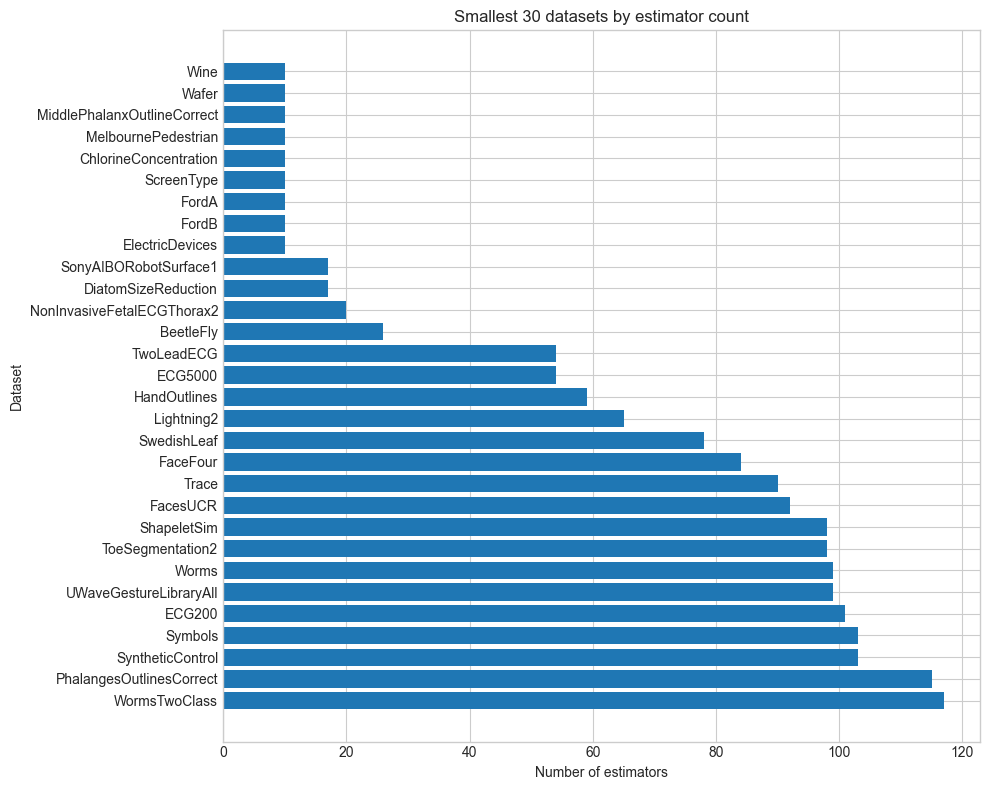

In [21]:
smallest_n = 30
least_complex = summary_df.head(smallest_n)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(least_complex['dataset'], least_complex['n_estimators'], color='#1f77b4')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Dataset')
ax.set_title(f'Smallest {smallest_n} datasets by estimator count')
ax.invert_yaxis()
plt.tight_layout()
plt.show()